# Prediction of housing prices using Random Forest Regression

## Importing libraries

In [54]:
import copy

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

## Reading datasets

In [55]:
TRAINING_SET_PATH = '../dataset/train.csv'
training_set = pd.read_csv(TRAINING_SET_PATH)

TESTING_SET_PATH = '../dataset/test.csv'
testing_set = pd.read_csv(TESTING_SET_PATH)

## Correlation Matrix

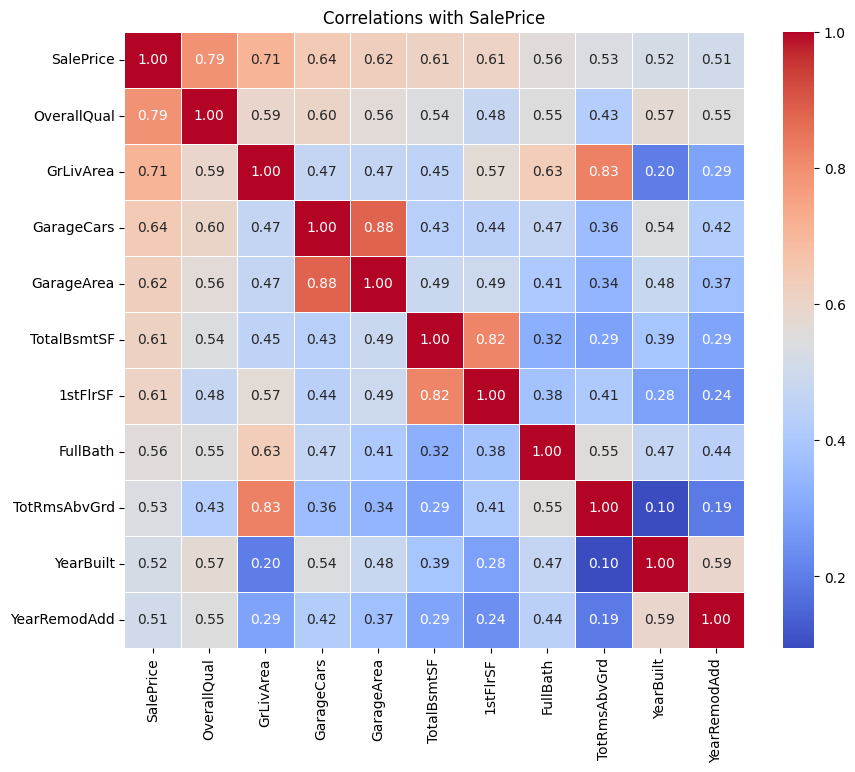

In [56]:
numeric = training_set.select_dtypes(include=['number'])
corr_numeric = numeric.corr()
corr_sorted = corr_numeric['SalePrice'].sort_values(ascending=False)
corr_high = corr_sorted[abs(corr_sorted) > 0.5].index
corr_numeric = corr_numeric.loc[corr_high, corr_high]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_numeric, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlations with SalePrice')
plt.show()

## Data Preprocessing

In [57]:
# Combining both sets to process together
print(f'Training set length: {len(training_set)}; Testing set lenth: {len(testing_set)}')
total_set = pd.concat([training_set, testing_set]).reset_index()
print(f'Total set length: {len(total_set)}')
testing_min_id = 1461

Training set length: 1460; Testing set lenth: 1459
Total set length: 2919


### Handling missing values

In [58]:
def display_missing_values(df):
    missing_values = df.isnull().sum().to_frame()
    missing_values.columns = ['Missing_Values']
    missing_values = missing_values.query('Missing_Values > 0')
    print(missing_values)

display_missing_values(total_set)

              Missing_Values
MSZoning                   4
LotFrontage              486
Alley                   2721
Utilities                  2
Exterior1st                1
Exterior2nd                1
MasVnrType              1766
MasVnrArea                23
BsmtQual                  81
BsmtCond                  82
BsmtExposure              82
BsmtFinType1              79
BsmtFinSF1                 1
BsmtFinType2              80
BsmtFinSF2                 1
BsmtUnfSF                  1
TotalBsmtSF                1
Electrical                 1
BsmtFullBath               2
BsmtHalfBath               2
KitchenQual                1
Functional                 2
FireplaceQu             1420
GarageType               157
GarageYrBlt              159
GarageFinish             159
GarageCars                 1
GarageArea                 1
GarageQual               159
GarageCond               159
PoolQC                  2909
Fence                   2348
MiscFeature             2814
SaleType      

In [59]:
cleaned_set = copy.deepcopy(total_set)

#### Handling Bsmt

Upon further inspection in the dataset, rows with NA *BsmtQual* have NA values for the rest of *BsmtColumns*

It would be suitable to create a new column of binary value to indicate whether the row has a *Bsmt*

In [60]:
# Inspecting rows with NA BsmtQual
mask = total_set['BsmtQual'].isna()

cat_cols = ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2')
num_cols = ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath')
cols = cat_cols+num_cols

total_set.loc[mask, cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
90,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
102,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
156,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2803,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2804,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2824,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2891,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Inspecting rows with non-NA BsmtQual
mask = total_set['BsmtQual'].notna()
total_set.loc[mask, cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
0,Gd,TA,No,GLQ,Unf,706.0,0.0,150.0,856.0,1.0,0.0
1,Gd,TA,Gd,ALQ,Unf,978.0,0.0,284.0,1262.0,0.0,1.0
2,Gd,TA,Mn,GLQ,Unf,486.0,0.0,434.0,920.0,1.0,0.0
3,TA,Gd,No,ALQ,Unf,216.0,0.0,540.0,756.0,1.0,0.0
4,Gd,TA,Av,GLQ,Unf,655.0,0.0,490.0,1145.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2914,TA,TA,No,Unf,Unf,0.0,0.0,546.0,546.0,0.0,0.0
2915,TA,TA,No,Rec,Unf,252.0,0.0,294.0,546.0,0.0,0.0
2916,TA,TA,No,ALQ,Unf,1224.0,0.0,0.0,1224.0,1.0,0.0
2917,Gd,TA,Av,GLQ,Unf,337.0,0.0,575.0,912.0,0.0,1.0


In [62]:
# Replaceing NA with an arbitrary value
mask = cleaned_set['BsmtQual'].isna()
cleaned_set.loc[mask, cat_cols] = str('NA')
cleaned_set.loc[mask, num_cols] = 0

display_missing_values(cleaned_set)

              Missing_Values
MSZoning                   4
LotFrontage              486
Alley                   2721
Utilities                  2
Exterior1st                1
Exterior2nd                1
MasVnrType              1766
MasVnrArea                23
BsmtCond                   3
BsmtExposure               3
BsmtFinType2               1
Electrical                 1
KitchenQual                1
Functional                 2
FireplaceQu             1420
GarageType               157
GarageYrBlt              159
GarageFinish             159
GarageCars                 1
GarageArea                 1
GarageQual               159
GarageCond               159
PoolQC                  2909
Fence                   2348
MiscFeature             2814
SaleType                   1
SalePrice               1459


In [63]:
# cleanup BsmtCond
mask = cleaned_set['BsmtCond'].isna()
cleaned_set.loc[mask, 'BsmtCond'] = str('NA')

# cleanup BsmtExposure
mask = cleaned_set['BsmtExposure'].isna()
cleaned_set.loc[mask, 'BsmtExposure'] = str('NA')

# cleanup BsmtFinType2
mask = cleaned_set['BsmtFinType2'].isna()
cleaned_set.loc[mask, 'BsmtFinType2'] = str('NA')

display_missing_values(cleaned_set)

              Missing_Values
MSZoning                   4
LotFrontage              486
Alley                   2721
Utilities                  2
Exterior1st                1
Exterior2nd                1
MasVnrType              1766
MasVnrArea                23
Electrical                 1
KitchenQual                1
Functional                 2
FireplaceQu             1420
GarageType               157
GarageYrBlt              159
GarageFinish             159
GarageCars                 1
GarageArea                 1
GarageQual               159
GarageCond               159
PoolQC                  2909
Fence                   2348
MiscFeature             2814
SaleType                   1
SalePrice               1459


#### Handling Garage

Upon further inspection in the dataset, rows with NA *GarageYrBlt* have NA values for the rest of *GarageColumns*

It would be suitable to create a new column of binary value to indicate whether the row has a garage

In [64]:
# Inspecting rows with NA YrBlt
mask = cleaned_set['GarageYrBlt'].isna()
cols = ('GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageCars', 'GarageArea')
cleaned_set.loc[mask, cols]

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0
48,NaN,NaN,NaN,NaN,NaN,0.0,0.0
78,NaN,NaN,NaN,NaN,NaN,0.0,0.0
88,NaN,NaN,NaN,NaN,NaN,0.0,0.0
89,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...
2893,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2909,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2913,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2914,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [65]:
#   Replaceing NA with an arbitrary value
mask = cleaned_set['GarageYrBlt'].isna()

#   Handling categorical features
cat_cols = ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond')
cleaned_set.loc[mask, cat_cols] = str('NA')

#   Handling numerical feature
num_cols = ('GarageYrBlt', 'GarageCars', 'GarageArea')
cleaned_set.loc[mask, num_cols] = 0

display_missing_values(cleaned_set)

             Missing_Values
MSZoning                  4
LotFrontage             486
Alley                  2721
Utilities                 2
Exterior1st               1
Exterior2nd               1
MasVnrType             1766
MasVnrArea               23
Electrical                1
KitchenQual               1
Functional                2
FireplaceQu            1420
PoolQC                 2909
Fence                  2348
MiscFeature            2814
SaleType                  1
SalePrice              1459


#### Handling Alley

In [66]:
mask = cleaned_set['Alley'].isna()
cleaned_set.loc[mask, 'Alley'] = str('NA')

display_missing_values(cleaned_set)

             Missing_Values
MSZoning                  4
LotFrontage             486
Utilities                 2
Exterior1st               1
Exterior2nd               1
MasVnrType             1766
MasVnrArea               23
Electrical                1
KitchenQual               1
Functional                2
FireplaceQu            1420
PoolQC                 2909
Fence                  2348
MiscFeature            2814
SaleType                  1
SalePrice              1459


#### Handling MasVnrType

In [67]:
mask = cleaned_set['MasVnrType'].isna()
cleaned_set.loc[mask, 'MasVnrType'] = str('None')
display_missing_values(cleaned_set)

             Missing_Values
MSZoning                  4
LotFrontage             486
Utilities                 2
Exterior1st               1
Exterior2nd               1
MasVnrArea               23
Electrical                1
KitchenQual               1
Functional                2
FireplaceQu            1420
PoolQC                 2909
Fence                  2348
MiscFeature            2814
SaleType                  1
SalePrice              1459


#### Handling MasVnrArea

In [68]:
mask = cleaned_set['MasVnrArea'].isna()
cleaned_set.loc[mask, 'MasVnrArea'] = 0
display_missing_values(cleaned_set)

             Missing_Values
MSZoning                  4
LotFrontage             486
Utilities                 2
Exterior1st               1
Exterior2nd               1
Electrical                1
KitchenQual               1
Functional                2
FireplaceQu            1420
PoolQC                 2909
Fence                  2348
MiscFeature            2814
SaleType                  1
SalePrice              1459


#### Handling FireplaceQu

Same approach for *FireplaceQu*

In [69]:
mask = cleaned_set['FireplaceQu'].isna()
cleaned_set.loc[mask, 'FireplaceQu'] = str('NA')
display_missing_values(cleaned_set)

             Missing_Values
MSZoning                  4
LotFrontage             486
Utilities                 2
Exterior1st               1
Exterior2nd               1
Electrical                1
KitchenQual               1
Functional                2
PoolQC                 2909
Fence                  2348
MiscFeature            2814
SaleType                  1
SalePrice              1459


#### Handling PoolQC

Same approach for *PoolQC*

In [70]:
mask = cleaned_set['PoolQC'].isna()
cleaned_set.loc[mask, 'PoolQC'] = str('NA')
display_missing_values(cleaned_set)

             Missing_Values
MSZoning                  4
LotFrontage             486
Utilities                 2
Exterior1st               1
Exterior2nd               1
Electrical                1
KitchenQual               1
Functional                2
Fence                  2348
MiscFeature            2814
SaleType                  1
SalePrice              1459


#### Handling Fence

Same approach for *Fence*

In [71]:
mask = cleaned_set['Fence'].isna()
cleaned_set.loc[mask, 'Fence'] = str('NA')
display_missing_values(cleaned_set)

             Missing_Values
MSZoning                  4
LotFrontage             486
Utilities                 2
Exterior1st               1
Exterior2nd               1
Electrical                1
KitchenQual               1
Functional                2
MiscFeature            2814
SaleType                  1
SalePrice              1459


#### Handling MiscFeature

Same approach for *MiscFeature*

In [72]:
mask = cleaned_set['MiscFeature'].isna()
cleaned_set.loc[mask, 'MiscFeature'] = str('NA')
display_missing_values(cleaned_set)

             Missing_Values
MSZoning                  4
LotFrontage             486
Utilities                 2
Exterior1st               1
Exterior2nd               1
Electrical                1
KitchenQual               1
Functional                2
SaleType                  1
SalePrice              1459


#### Handling LotFrontage

Since not all housing properties have lot frontage, such as apartments, it would be better to preserve the implication in the original dataset, instead of making up an approximate value.

In [73]:
mask = cleaned_set['LotFrontage'].isna()
cleaned_set.loc[mask, 'LotFrontage'] = 0

display_missing_values(cleaned_set)

             Missing_Values
MSZoning                  4
Utilities                 2
Exterior1st               1
Exterior2nd               1
Electrical                1
KitchenQual               1
Functional                2
SaleType                  1
SalePrice              1459


#### Handling misc NAs

In [74]:
mask = cleaned_set['MSZoning'].isna()
cleaned_set.loc[mask, 'MSZoning'] = str('NA')

mask = cleaned_set['Utilities'].isna()
cleaned_set.loc[mask, 'Utilities'] = str('NA')

mask = cleaned_set['Exterior1st'].isna()
cleaned_set.loc[mask, 'Exterior1st'] = str('Other')

mask = cleaned_set['Exterior2nd'].isna()
cleaned_set.loc[mask, 'Exterior2nd'] = str('Other')

mask = cleaned_set['Electrical'].isna()
cleaned_set.loc[mask, 'Electrical'] = str('NA')

mask = cleaned_set['KitchenQual'].isna()
cleaned_set.loc[mask, 'KitchenQual'] = str('NA')

mask = cleaned_set['Functional'].isna()
cleaned_set.loc[mask, 'Functional'] = str('NA')

mask = cleaned_set['SaleType'].isna()
cleaned_set.loc[mask, 'SaleType'] = str('Oth')

display_missing_values(cleaned_set)

           Missing_Values
SalePrice            1459


### Standardising numerical features

In [75]:
# Getting numerical columns
num_features = cleaned_set.select_dtypes(include=['number']).columns.drop('Id')
num_features

Index(['index', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

#### Plotting distributions of numerical features

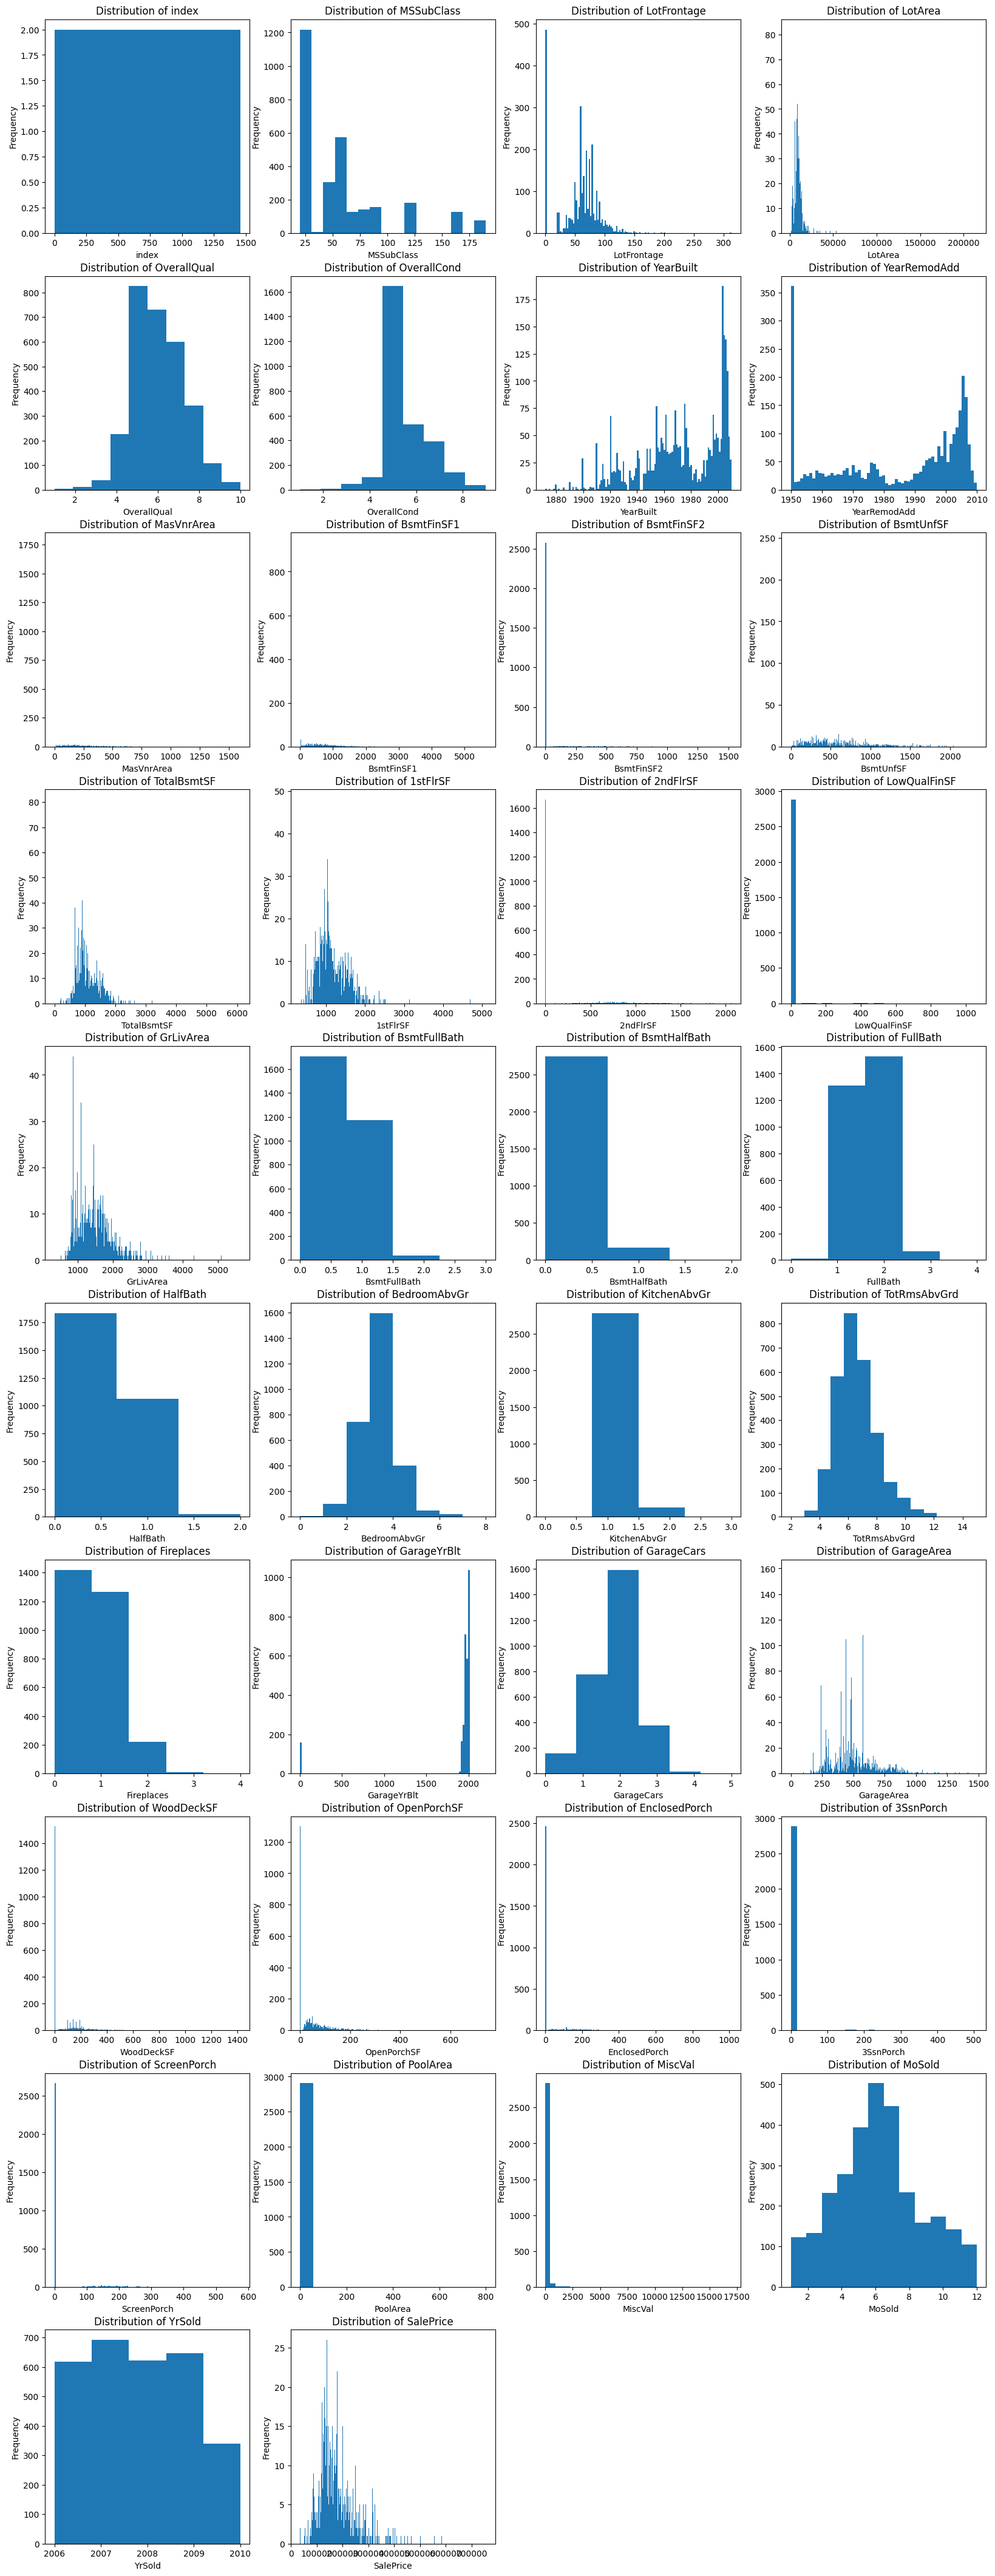

In [76]:
def plot_dfs(features):
    # Setting up subplots
    plot_per_row = 4
    rows = len(features) // plot_per_row
    fig, axes = plt.subplots(rows+1, plot_per_row, figsize=(20, 6*rows))
    axes = axes.flatten()

    # Plotting each subplot
    for i, feature in enumerate(features):
        ax = axes[i]
        ax.hist(cleaned_set[feature], bins=len(cleaned_set[feature].unique()))
        ax.set_title(f'Distribution of {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')

    # Turning off unused subplot
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

plot_dfs(num_features)

#### Standardising suitable features

Obsered in the plot of each feature's distribution, and it seems the following features should be standardised:
*LotArea*, *BsmtFinSF1*, *TotalBsmtSF*, *1stFlrSF*, *GrLivArea*

C:\Users\User\AppData\Local\Temp\ipykernel_12456\2267113793.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.20714171 -0.09188637  0.07347998 ... -0.14781027 -0.08016039
 -0.05811155]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cleaned_set.loc[mask, standardised_features] = scaler.fit_transform(cleaned_set.loc[mask, standardised_features])
C:\Users\User\AppData\Local\Temp\ipykernel_12456\2267113793.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.37033344 -0.48251191  0.51501256 ...  1.56964722 -0.83278768
 -0.49393395]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cleaned_set.loc[mask, standardised_features] = scaler.fit_transform(cleaned_set.loc[mask, standardised_features])
c:\Users\User\Documents\SideProject\house-pr

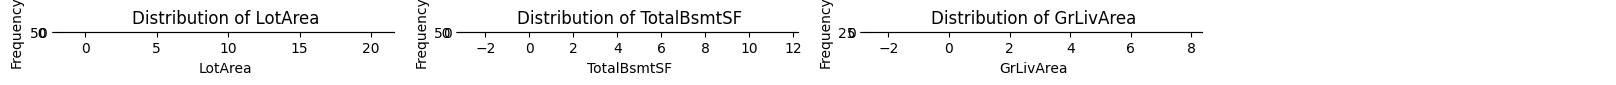

In [77]:
scaler = StandardScaler()
standardised_features = ['LotArea', 'TotalBsmtSF', 'GrLivArea']

# Scale within training set
mask = cleaned_set['Id'] < testing_min_id
cleaned_set.loc[mask, standardised_features] = scaler.fit_transform(cleaned_set.loc[mask, standardised_features])

# Scale within testing set
mask = cleaned_set['Id'] >= testing_min_id
cleaned_set.loc[mask, standardised_features] = scaler.transform(cleaned_set.loc[mask, standardised_features])

plot_dfs(standardised_features)

#### Standardising target

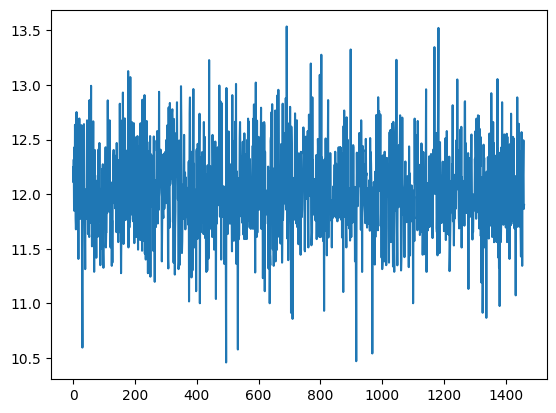

In [78]:
# Scale within training set
mask = cleaned_set['Id'] < testing_min_id
cleaned_set.loc[mask, 'SalePrice'] = np.log1p(cleaned_set.loc[mask, 'SalePrice'])

plt.plot(cleaned_set.loc[mask, 'SalePrice'])

### Binary Transformation

In [79]:
#Convert the columns 'CentralAir' from (Y/N) to (1/0)
cleaned_set['CentralAir'] = cleaned_set['CentralAir'].replace({'Y': 1, 'N': 0})

#Convert the data in the column 'Street' to binary, where 'Pave' to 1 and 'Grvl' to 0.
cleaned_set['Street'] = cleaned_set['Street'].replace({'Pave': 1, 'Grvl': 0})

#Convert the data in the column 'Alley' to binary.
#The way of doing it is to group 'Pave' and 'Grvl'
#If the property has an alley access, then 1; 
#Otherwise 0.
cleaned_set['Alley'] = cleaned_set['Alley'].replace({'Pave': 1, 'Grvl': 1, str('NA'): 0})

#Convert the data in the column 'LotShape' to binary, where 'Reg' to 1 and grouping 'IR1', 'IR2' and 'IR3' to 0.
#If the shape of the property is regular, then 1;
#Otherwise 0.
cleaned_set['LotShape'] = cleaned_set['LotShape'].replace({'Reg': 1, 'IR1': 0, 'IR2': 0, 'IR3': 0})

#Convert the data in the column 'LandContour' to binary, where 'Lvl' to 1 and grouping 'Bnk', 'HLS' and 'Low' to 0.
#If the property is near flat/level, then 1;
#Otherwise 0.
cleaned_set['LandContour'] = cleaned_set['LandContour'].replace({'Lvl': 1, 'Bnk': 0, 'HLS': 0, 'Low': 0})

#Convert the data in the column 'Utilities' to binary, where 'AllPub' to 1 and grouping 'NoSewr', 'NoSeWa' and 'ELO' to 0.
#If all type of utilities is available, then 1;
#Otherwise 0.
cleaned_set['Utilities'] = cleaned_set['Utilities'].replace({'AllPub': 1, 'NoSewr': 0, 'NoSeWa': 0, 'ELO': 0, str('NA'): 0})

C:\Users\User\AppData\Local\Temp\ipykernel_12456\2515209323.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_set['CentralAir'] = cleaned_set['CentralAir'].replace({'Y': 1, 'N': 0})
C:\Users\User\AppData\Local\Temp\ipykernel_12456\2515209323.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_set['Street'] = cleaned_set['Street'].replace({'Pave': 1, 'Grvl': 0})
C:\Users\User\AppData\Local\Temp\ipykernel_12456\2515209323.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a

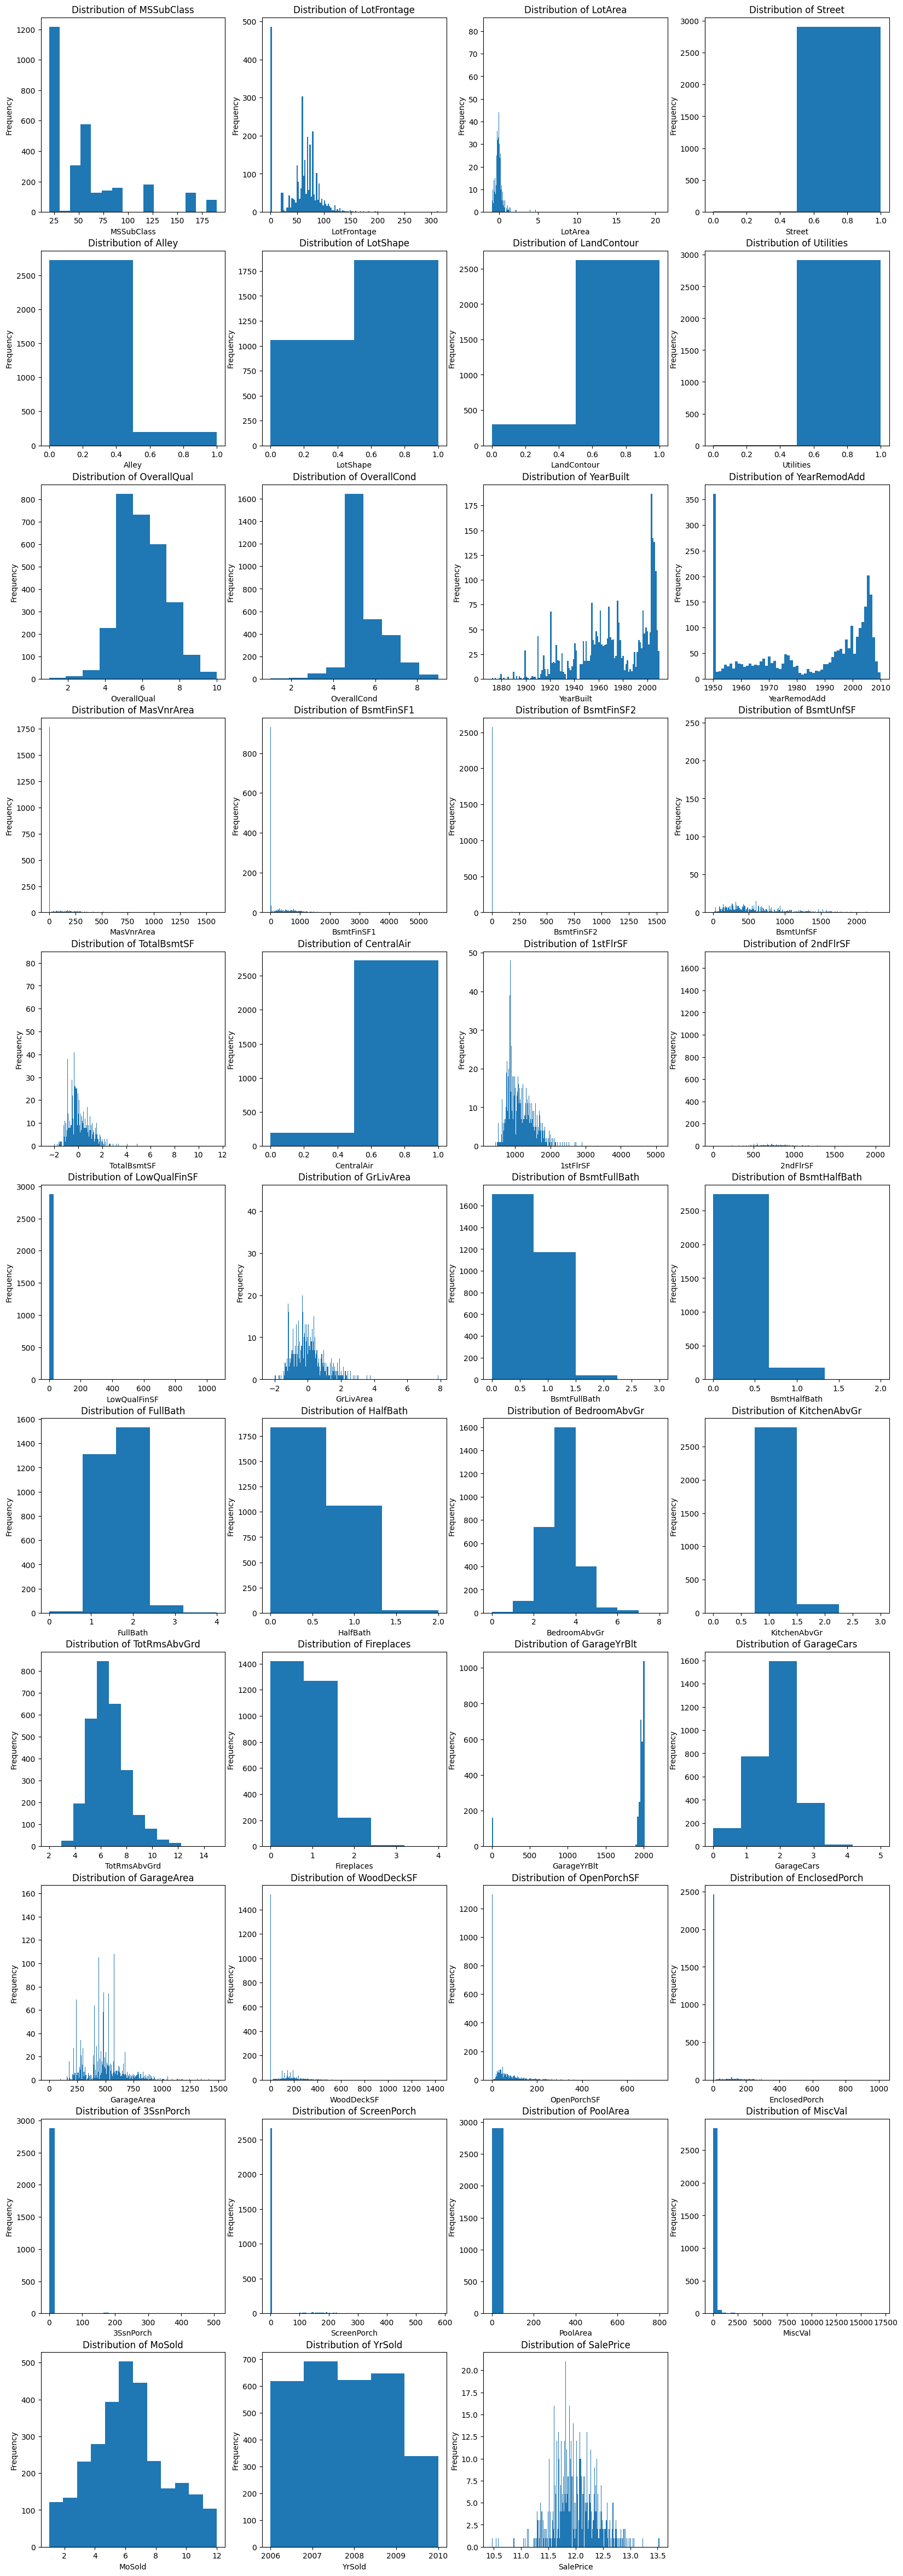

In [80]:
num_features = cleaned_set.select_dtypes(include=['number']).columns.drop(['Id', 'index'])
plot_dfs(num_features)

### Encoding categorical features

In [81]:
# Getting categorical columns
cat_cols = cleaned_set.select_dtypes(include=['object']).columns
cat_cols

Index(['MSZoning', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

#### Encoding categorical columns using OrdinalEncoder

It is noted that not all categorical columns are ordinal features.

Despite the added implication, it doesn't really matter that nominal values are treated as such.

In [82]:
ord_enc = OrdinalEncoder()
ord_enc.fit(cleaned_set.loc[:, cat_cols])
encoded_cat = ord_enc.transform(cleaned_set.loc[:, cat_cols])
encoded_cat

array([[4., 4., 0., ..., 1., 8., 4.],
       [4., 2., 0., ..., 1., 8., 4.],
       [4., 4., 0., ..., 1., 8., 4.],
       ...,
       [4., 4., 0., ..., 1., 8., 0.],
       [4., 4., 0., ..., 3., 8., 4.],
       [4., 4., 1., ..., 1., 8., 4.]], shape=(2919, 37))

#### Subtituting encoded categorical features into the dataset

In [83]:
cleaned_set.loc[:, cat_cols] = encoded_cat
cleaned_set.loc[:, cat_cols]

,MSZoning,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,4.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,1.0,1.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
1,4.0,2.0,0.0,24.0,1.0,2.0,0.0,2.0,1.0,1.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
2,4.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,1.0,1.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
3,4.0,0.0,0.0,6.0,2.0,2.0,0.0,5.0,1.0,1.0,...,5.0,3.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,0.0
4,4.0,2.0,0.0,15.0,2.0,2.0,0.0,5.0,1.0,1.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,5.0,4.0,0.0,10.0,2.0,2.0,3.0,5.0,1.0,1.0,...,6.0,1.0,3.0,3.0,2.0,3.0,4.0,1.0,8.0,4.0
2915,5.0,4.0,0.0,10.0,2.0,2.0,4.0,5.0,1.0,1.0,...,4.0,3.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,0.0
2916,4.0,4.0,0.0,11.0,2.0,2.0,0.0,2.0,1.0,1.0,...,5.0,3.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,0.0
2917,4.0,4.0,0.0,11.0,2.0,2.0,0.0,6.0,1.0,1.0,...,6.0,1.0,3.0,3.0,2.0,3.0,2.0,3.0,8.0,4.0


### Feature Engineering

In [84]:
cleaned_set.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], axis=1, inplace=True) # TotalBsmtSF includes all this info

cleaned_set['HighQualFlrSF'] = cleaned_set['1stFlrSF'] + cleaned_set['2ndFlrSF']
cleaned_set.drop(['1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

cleaned_set['TotalBath'] = cleaned_set['FullBath'] + cleaned_set['HalfBath'] * 0.5 + cleaned_set['BsmtFullBath'] + cleaned_set['BsmtHalfBath'] * 0.5
cleaned_set.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)

cleaned_set['OverallRate'] = cleaned_set['OverallQual'] + cleaned_set['OverallCond']
cleaned_set.drop(['OverallQual', 'OverallCond'], axis=1, inplace=True)

cleaned_set['TotalPorch'] = cleaned_set['OpenPorchSF'] + cleaned_set['EnclosedPorch'] + cleaned_set['3SsnPorch'] + cleaned_set['ScreenPorch']
cleaned_set.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1, inplace=True)

cleaned_set['has_garage'] = cleaned_set['GarageArea'].apply(lambda x: 1 if x>0 else 0)
cleaned_set['has_pool'] = cleaned_set['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
cleaned_set['has_bsmt'] = cleaned_set['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
cleaned_set['has_fireplace'] = cleaned_set['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
cleaned_set['has_porch'] = cleaned_set['TotalPorch'].apply(lambda x: 1 if x > 0 else 0)

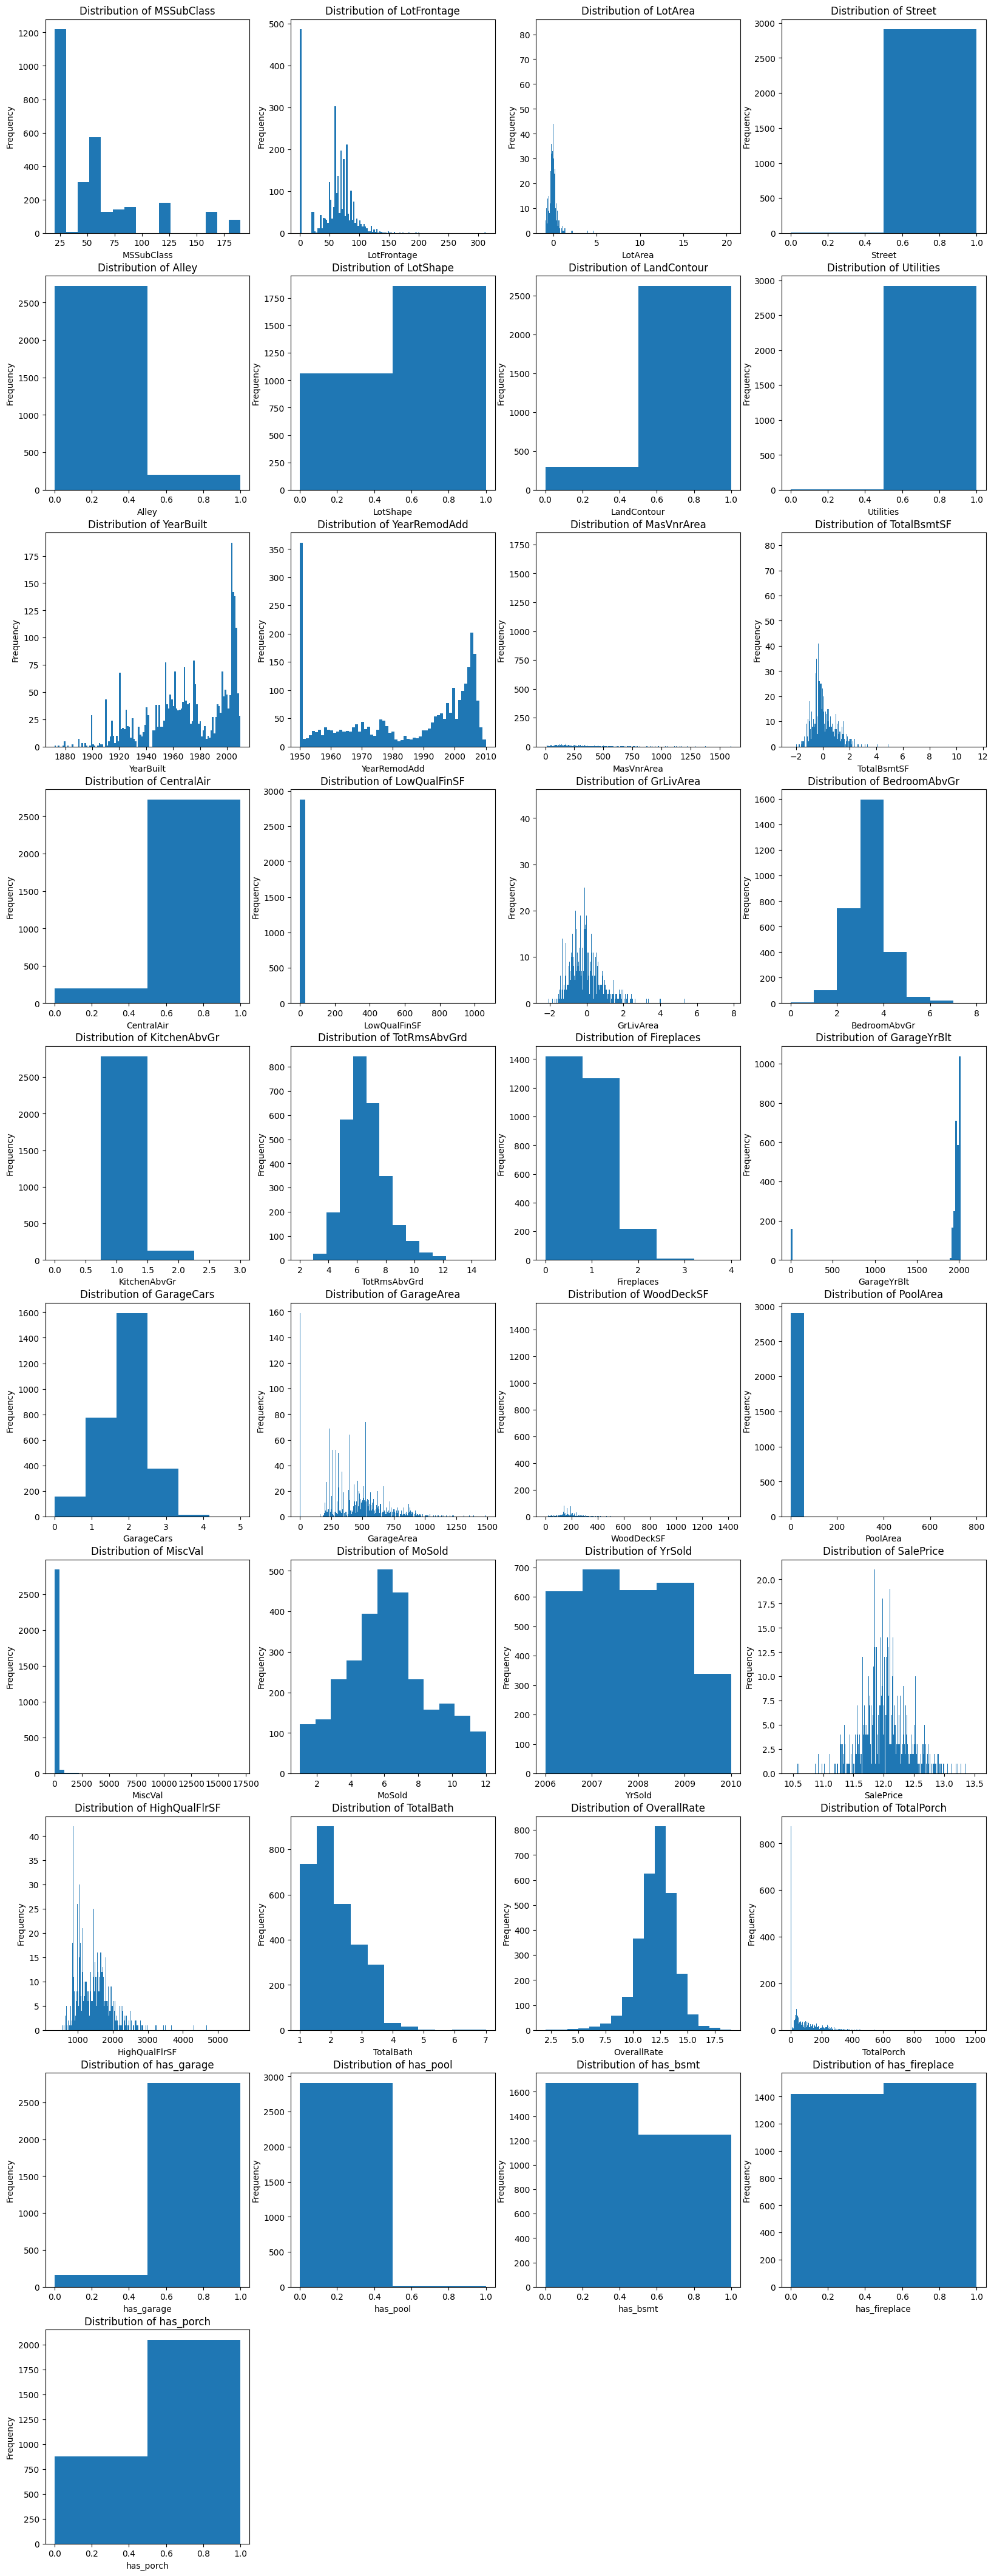

In [85]:
num_features = cleaned_set.select_dtypes(include=['number']).columns.drop(['Id', 'index'])
plot_dfs(num_features)

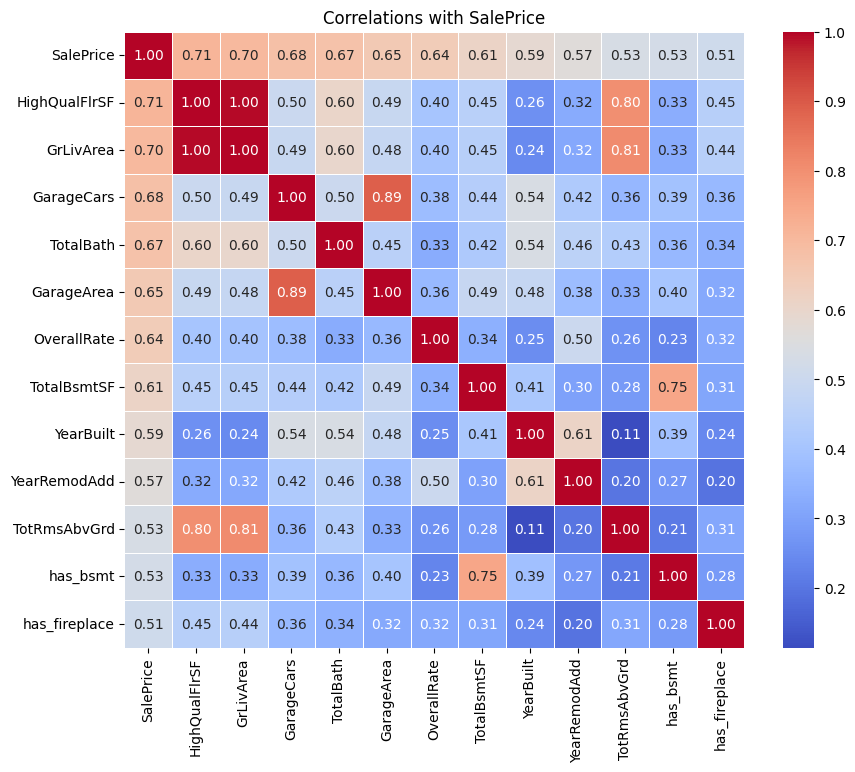

In [86]:
numeric = cleaned_set.select_dtypes(include=['number'])
corr_numeric = numeric.corr()
corr_sorted = corr_numeric['SalePrice'].sort_values(ascending=False)
corr_high = corr_sorted[abs(corr_sorted) > 0.5].index
corr_numeric = corr_numeric.loc[corr_high, corr_high]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_numeric, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlations with SalePrice')
plt.show()

In [87]:
cleaned_set.drop('GrLivArea', axis=1, inplace=True)

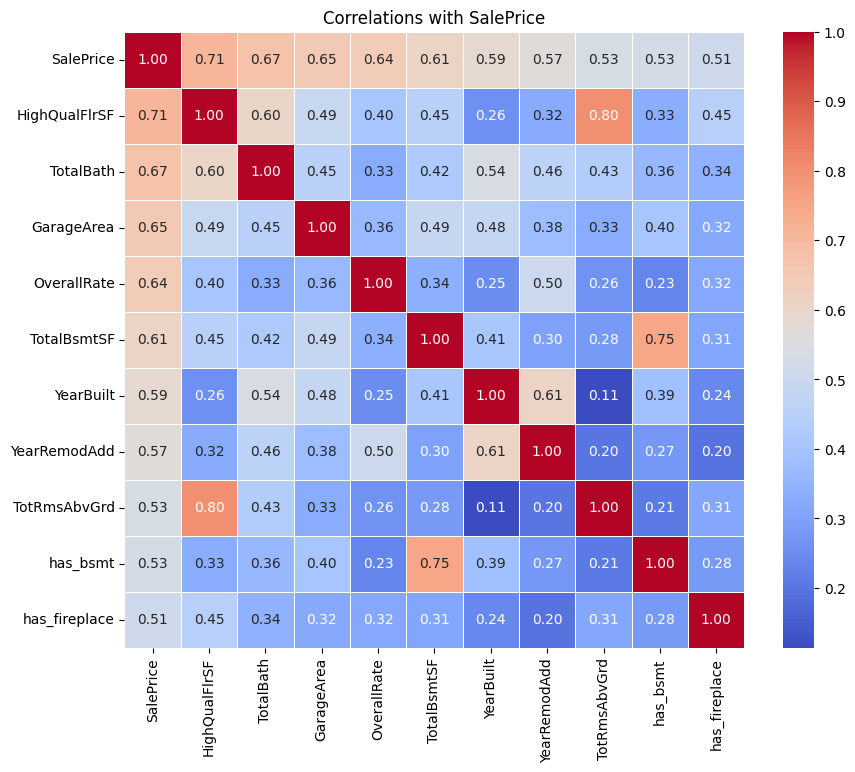

In [89]:
numeric = cleaned_set.select_dtypes(include=['number'])
corr_numeric = numeric.corr()
corr_sorted = corr_numeric['SalePrice'].sort_values(ascending=False)
corr_high = corr_sorted[abs(corr_sorted) > 0.5].index
corr_numeric = corr_numeric.loc[corr_high, corr_high]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_numeric, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlations with SalePrice')
plt.show()

## Seperating training and testing sets

In [90]:
mask = cleaned_set['Id'] < testing_min_id
train = copy.deepcopy(cleaned_set.loc[mask, :]).reset_index().drop(['index', 'level_0'], axis=1)

mask = cleaned_set['Id'] >= testing_min_id
test = copy.deepcopy(cleaned_set.loc[mask, :]).reset_index().drop(['index', 'level_0'], axis=1)

print(f'Training set length: {len(train)}; Testing set length: {len(test)}')

Training set length: 1460; Testing set length: 1459


## Building model

In [91]:
models = {
    "gbr": GradientBoostingRegressor(verbose=0),
    "br": BayesianRidge(),
    "omp": OrthogonalMatchingPursuit(),
    "et": ExtraTreesRegressor(),
    "ridge": Ridge()
}

X_train = train.drop(['Id', 'SalePrice'], axis=1)
y_train = train.loc[:, 'SalePrice']

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

gbr trained.
br trained.
omp trained.
et trained.
ridge trained.


In [92]:
# R^2 of training set
scores = [model.score(X_train, y_train) for _, model in models.items()]
scores

[0.95511571951968,
 0.8810448414838703,
 0.7474577088997743,
 1.0,
 0.8853062589762214]

In [93]:
X_test = test.drop(['Id', 'SalePrice'], axis=1)
X_test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleCondition,HighQualFlrSF,TotalBath,OverallRate,TotalPorch,has_garage,has_pool,has_bsmt,has_fireplace,has_porch
0,20,3.0,80.0,0.110763,1,0,1,1,1,4.0,...,4.0,896,1.0,11,120,1,0,0,0,1
1,20,4.0,81.0,0.375850,1,0,0,1,1,0.0,...,4.0,1329,1.5,12,36,1,0,1,0,1
2,60,4.0,74.0,0.332053,1,0,0,1,1,4.0,...,4.0,1629,2.5,10,34,1,0,0,1,1
3,60,4.0,78.0,-0.054002,1,0,0,1,1,4.0,...,4.0,1604,2.5,12,36,1,0,0,1,1
4,120,4.0,43.0,-0.552407,1,0,0,0,1,4.0,...,4.0,1280,2.0,13,226,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,5.0,21.0,-0.859988,1,0,1,1,1,4.0,...,4.0,1092,1.5,11,0,0,0,0,0,0
1455,160,5.0,21.0,-0.864197,1,0,1,1,1,4.0,...,0.0,1092,1.5,9,24,1,0,0,0,1
1456,20,4.0,160.0,0.950423,1,0,1,1,1,4.0,...,0.0,1224,2.0,12,0,1,0,1,1,0
1457,85,4.0,62.0,-0.007600,1,0,1,1,1,4.0,...,4.0,970,1.5,10,32,0,0,0,0,1


In [94]:
y_preds = {name: np.exp(model.predict(X_test)) for name, model in models.items() }
y_preds

{'gbr': array([125341.19453492, 156147.71051589, 172341.93363688, ...,
        161872.47091173, 125221.04309563, 224644.37623307], shape=(1459,)),
 'br': array([118378.96708387, 149745.71606062, 167837.57066213, ...,
        158156.63382577, 114357.99406018, 226424.47534457], shape=(1459,)),
 'omp': array([141049.17606552, 148929.88870369, 200354.41016558, ...,
        158286.67058723, 115954.91758161, 239074.48106016], shape=(1459,)),
 'et': array([117994.73948967, 148065.11102532, 178369.92723372, ...,
        154169.95850808, 117214.43152225, 206946.7958124 ], shape=(1459,)),
 'ridge': array([117770.84491391, 158531.81041854, 166029.66430118, ...,
        159334.94469538, 114555.62356596, 225822.86265416], shape=(1459,))}

In [95]:
y_true = pd.read_csv('../dataset/sample_submission.csv').drop('Id', axis=1)
y_true

,SalePrice
0,169277.052498
1,187758.393989
2,183583.683570
3,179317.477511
4,150730.079977
...,...
1454,167081.220949
1455,164788.778231
1456,219222.423400
1457,184924.279659


In [96]:
MSEs = {name: mean_squared_error(y_true=y_true, y_pred=y_preds[name]) for name, _ in models.items()}
MSEs

{'gbr': 5378088102.096445,
 'br': 4925762118.822555,
 'omp': 4405190989.049916,
 'et': 4648167789.576766,
 'ridge': 5005138062.989562}